In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skmultilearn.model_selection import iterative_train_test_split
# from wandb.keras import WandbCallback
# import wandb
# wandb.init(project='smartpot',
#           config = {
#                     'learning_rate': 1e-4,
#                     'epochs': 10,
#                     'batch_size': 30,
#                     'drop_out' : 0.5,
#                     'dense' : 1024
#                 })

# config = wandb.config

2022-06-14 17:09:52.743268: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
tf.__version__

'2.4.1'

In [4]:
IMAGE_SIZE = 320
MODEL_IMAGE_SIZE = 224
BATCH_SIZE = 50 #################################

# Data Load

In [5]:
df = pd.read_csv('../../../data/small_down_sampled_lettuce.csv')
df.head()

,image,disease,area,grow,points,original,disease-grow
0,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,3,11,"[{'xtl': 2034, 'ytl': 1153, 'xbr': 2436, 'ybr'...",NaN,0-11
1,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,3,11,"[{'xtl': 1513, 'ytl': 676, 'xbr': 2325, 'ybr':...",NaN,0-11
2,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,3,11,"[{'xtl': 1438, 'ytl': 1142, 'xbr': 2442, 'ybr'...",NaN,0-11
3,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,3,11,"[{'xtl': 2269, 'ytl': 1515, 'xbr': 2991, 'ybr'...",NaN,0-11
4,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,3,11,"[{'xtl': 480, 'ytl': 170, 'xbr': 1790, 'ybr': ...",NaN,0-11


In [6]:
# label encoding
disease_encoder = LabelEncoder()
disease_encoder.fit(df['disease'])
df['disease'] = disease_encoder.transform(df['disease'])
print(df['disease'].unique())

grow_encoder = LabelEncoder()
grow_encoder.fit(df['grow'])
df['grow'] = grow_encoder.transform(df['grow'])
print(df['grow'].unique())

[0 1 2]
[0 1]


In [7]:
shuffled_df = df.sample(frac=1)

In [8]:
%%time
X = df['image'].to_numpy().reshape(-1,1)
Y = df[['disease', 'grow']].to_numpy()
X_train, y_train, X_test, y_test = iterative_train_test_split(X,Y,test_size=0.20)

CPU times: user 193 ms, sys: 11.1 ms, total: 204 ms
Wall time: 174 ms


In [9]:
X_train = X_train.reshape(1,-1)
y_train = y_train.reshape(2,-1)
train_df = pd.DataFrame({'image':X_train[0, :],
                         'disease' : y_train[0,:],
                         'grow':y_train[1,:]})
print(len(train_df))
train_df.head()

2605


,image,disease,grow
0,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,1
1,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,1
2,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,1
3,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,1
4,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,1


In [10]:
X_test = X_test.reshape(1,-1)
y_test = y_test.reshape(2,-1)
test_df = pd.DataFrame({'image':X_test[0, :],
                         'disease' : y_test[0,:],
                         'grow':y_test[1,:]})
print(len(test_df))
test_df.head()

652


,image,disease,grow
0,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,1
1,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,1
2,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,1
3,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,1
4,/home/lab38/images/상추_정상/V006_77_0_00_05_03_11...,0,1


In [11]:
train_gen = ImageDataGenerator(rescale=1./255,
                            rotation_range=20, # 최대 20도까지 회전
                            width_shift_range=0.1, # 최대 x 범위안에서 좌우/상하 이동
                            height_shift_range=0.1,
                            zoom_range=0.2, # 확대 축소 비율,
                            horizontal_flip=True, # 좌우반전
                            vertical_flip=True, # 상하반전
                            fill_mode='nearest')
valid_gen = ImageDataGenerator(rescale= 1. /255.)

In [12]:
train_generator = train_gen.flow_from_dataframe(train_df, 
                                               x_col='image',
                                               y_col=['disease', 'grow'],
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='multi_output',
                                               batch_size=BATCH_SIZE)
valid_generator = valid_gen.flow_from_dataframe(test_df,
                                               x_col='image',
                                               y_col=['disease','grow'],
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='multi_output',
                                               batch_size=BATCH_SIZE)

Found 2605 validated image filenames.
Found 652 validated image filenames.


# Model

In [13]:
tf.keras.backend.clear_session()

In [14]:
with tf.device("/cpu:0"):
    base_model= resnet50.ResNet50(
          weights='imagenet',
          include_top=False,
         )


    base_model.trainable = False 

2022-06-14 17:09:54.366507: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-14 17:09:54.367601: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-14 17:09:54.446876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 17:09:54.447515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-06-14 17:09:54.447567: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-14 17:09:54.449149: I tensorflow/stream_executor/platform/default/dso_loade

In [15]:
input_data = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
resizing = Model(inputs=input_data, outputs=x, name='resize')

In [21]:
with tf.device("/cpu:0"):
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = resizing(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    backbone_out = layers.Dense(1024, activation='softmax')(x)

    disease_outputs = layers.Dense(df['disease'].nunique(), activation='softmax',
                            name = 'diease_outputs')(backbone_out)
    grow_outputs = layers.Dense(1, activation='sigmoid',
                        name = 'grow_outputs')(backbone_out)

    model = Model(inputs=inputs, 
                  outputs=[disease_outputs, grow_outputs],
                  name='lettuce')

In [22]:
model.summary()

Model: "lettuce"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
resize (Functional)             (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
resnet50 (Functional)           (None, None, None, 2 23587712    resize[1][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           resnet50[1][0]                   
____________________________________________________________________________________________

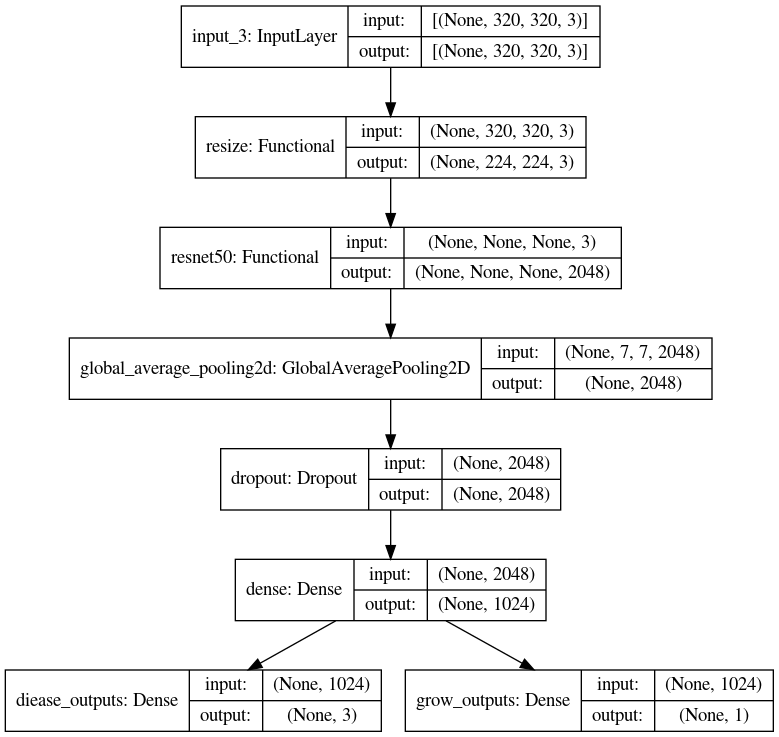

In [18]:
#keras.utils.plot_model(model, show_shapes=True)

In [23]:
model.compile(loss={
                  'diease_outputs' : 'sparse_categorical_crossentropy',
                  'grow_outputs' : 'binary_crossentropy'
              },
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy']) # 필요시 f1 score metrics custom

In [ ]:
model.fit(train_generator,
      validation_data=valid_generator,
      verbose=1,
      epochs=10,
      steps_per_epoch=len(train_df)//BATCH_SIZE)

Epoch 1/10
52/52 [==============================] - 570s 11s/step - loss: 1.7775 - diease_outputs_loss: 1.0939 - grow_outputs_loss: 0.6836 - diease_outputs_accuracy: 0.6428 - grow_outputs_accuracy: 0.6944 - val_loss: 1.7530 - val_diease_outputs_loss: 1.0803 - val_grow_outputs_loss: 0.6728 - val_diease_outputs_accuracy: 0.7393 - val_grow_outputs_accuracy: 1.0000
Epoch 2/10
52/52 [==============================] - 534s 10s/step - loss: 1.7314 - diease_outputs_loss: 1.0760 - grow_outputs_loss: 0.6553 - diease_outputs_accuracy: 0.7402 - grow_outputs_accuracy: 0.7179 - val_loss: 1.7208 - val_diease_outputs_loss: 1.0617 - val_grow_outputs_loss: 0.6590 - val_diease_outputs_accuracy: 0.7393 - val_grow_outputs_accuracy: 1.0000
Epoch 3/10
52/52 [==============================] - 527s 10s/step - loss: 1.6918 - diease_outputs_loss: 1.0570 - grow_outputs_loss: 0.6348 - diease_outputs_accuracy: 0.7419 - grow_outputs_accuracy: 0.7124 - val_loss: 1.6905 - val_diease_outputs_loss: 1.0429 - val_grow_out